In [1]:
import pandas as pd
from ord_data_load import ORD_PATH, is_reaction_of_type, df_na_vals
from chem_render import draw_reaction, indigo
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


%load_ext autoreload
%autoreload 2

In [2]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

CPU times: total: 5.59 s
Wall time: 5.59 s


In [3]:
df_na_vals(df)

rxn_smiles        ->       Missing values: 7 (0.00%)


TypeError: bad operand type for unary ~: 'float'

## Compare Suzuki substructure searches for USPTO database

In [7]:
SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"

In [8]:
%%time
rdkit_query = ReactionFromSmarts(SUZUKI_PATTERN)
suzuki_rdkit = df['rxn_smiles'][:10000].apply(is_reaction_of_type, args=(rdkit_query,))
suzuki_rdkit.sum()

CPU times: total: 5.08 s
Wall time: 5.08 s


149

In [9]:
# rdkit search

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_rdkit = dds.apply(is_reaction_of_type,
                         reaction_type_pattern=rdkit_query,
                         meta=pd.Series(dtype=bool)).compute(scheduler='processes') # rdkit functions are not parallelizable using "threads"
suzuki_rdkit.sum()

[########################################] | 100% Completed | 80.54 s
[########################################] | 100% Completed | 80.63 s


52577

In [10]:
# indigo search

query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    return True if indigo.substructureMatcher(indigo.loadReaction(rxn_smiles)).match(query) else False

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo = dds.apply(rxn_match,
                 # args=[query,),
                 # rxn_query=query,
                 meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo.sum()

[########################################] | 100% Completed | 236.33 s
[########################################] | 100% Completed | 236.42 s


49272

### Debug is_reaction_type

In [11]:
# from rdkit.Chem import MolFromSmiles as smiles2mol
#
# id = "ord-0bc171163cc04932b98554480b9c571f"
#
# reaction_to_test = df.loc[id, 'rxn_smiles']
# reactants = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[0].split('.'))))
# actual_products = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[-1].split('.'))))
#
# for r in reactants: display(r)
# for p in actual_products: display(p)


In [12]:
# SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"
# rdkit_query = ReactionFromSmarts(SUZUKI_PATTERN)
#
# print(is_reaction_of_type(reaction_to_test, rdkit_query))
# from copy import deepcopy
#
# reaction_type_pattern = rdkit_query
#
# if reaction_to_test is None:
#     print(False)
#
# if isinstance(reaction_to_test, str):
#     reactants = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[0].split('.'))))
#     actual_products = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[-1].split('.'))))
#
# else:
#     reactants = reaction_to_test.GetReactants()
#     actual_products = reaction_to_test.GetProducts()
#
#
# if isinstance(reaction_type_pattern, str):
#     # use input string to make an RdKit reaction and molecules
#     reactants_patterns = tuple(smiles2mol(smiles) for smiles in reaction_type_pattern.split('>')[0].split('.'))
#     reaction_type_pattern = ReactionFromSmarts(reaction_type_pattern)
#
#
# # target reactants to be extracted from the target reaction
# reactants_patterns = reaction_type_pattern.GetReactants()
#
#
# reactants_to_test = []
# for r_pattern in reactants_patterns:
#     for r, reactant in enumerate(reactants):
#         if reactant is None:
#             continue
#         reactant.UpdatePropertyCache()
#         if reactant.HasSubstructMatch(r_pattern):
#             # the reactant matches with the pattern
#             reactants_to_test.append(deepcopy(reactant))
#             break # stop searching
#     else:
#         # no reactant in the input reaction matched with the pattern
#         print("no reactant in the input reaction matched with the pattern")
#
# for p in actual_products:
#     p.UpdatePropertyCache()
#
# estimated_products = []
# for product, *_ in reaction_type_pattern.RunReactants(reactants_to_test, maxProducts=10):
#     try:
#         product.UpdatePropertyCache()
#         estimated_products.append(product)
#     except:
#         pass
#
# if len(estimated_products) == 0:
#     print("len(estimated_products) == 0")
#
# print(any(any(pred.HasSubstructMatch(obs) for obs in actual_products)  # any of the actual products matches the predicted product
#            for pred in estimated_products))  # for any of the predicted products
#
# for pred in estimated_products:
#     display(pred)


In [13]:
# rxn_smarts = df.loc[id, 'rxn_smiles']
#
# print('rdkit ', is_reaction_of_type(
#     ReactionFromSmarts(rxn_smarts),
#     ReactionFromSmarts(SUZUKI_PATTERN))
# )
#
# if indigo.substructureMatcher(indigo.loadReaction(rxn_smarts)).match(query):
#     print('indigo', True)
# else:
#     print('indigo', False)

In [14]:
print("{indigo}          : ", suzuki_indigo.sum())
print("{rdkit}           : ", suzuki_rdkit.sum())
print("{indigo} - {rdkit}: ", (suzuki_indigo & ~suzuki_rdkit).sum())
print("{rdkit} - {indigo}: ", (suzuki_rdkit & ~suzuki_indigo).sum())
print("{rdkit} ∪ {indigo}: ", (suzuki_rdkit | suzuki_indigo).sum())
print("{rdkit} ∩ {indigo}: ", (suzuki_rdkit & suzuki_indigo).sum())

{indigo}          :  49272
{rdkit}           :  52577
{indigo} - {rdkit}:  4088
{rdkit} - {indigo}:  7393
{rdkit} ∪ {indigo}:  56665
{rdkit} ∩ {indigo}:  45184


In [15]:
unique_rdkit = df[suzuki_rdkit & ~suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_33132\415057053.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_rdkit = df[suzuki_rdkit & ~suzuki_indigo]


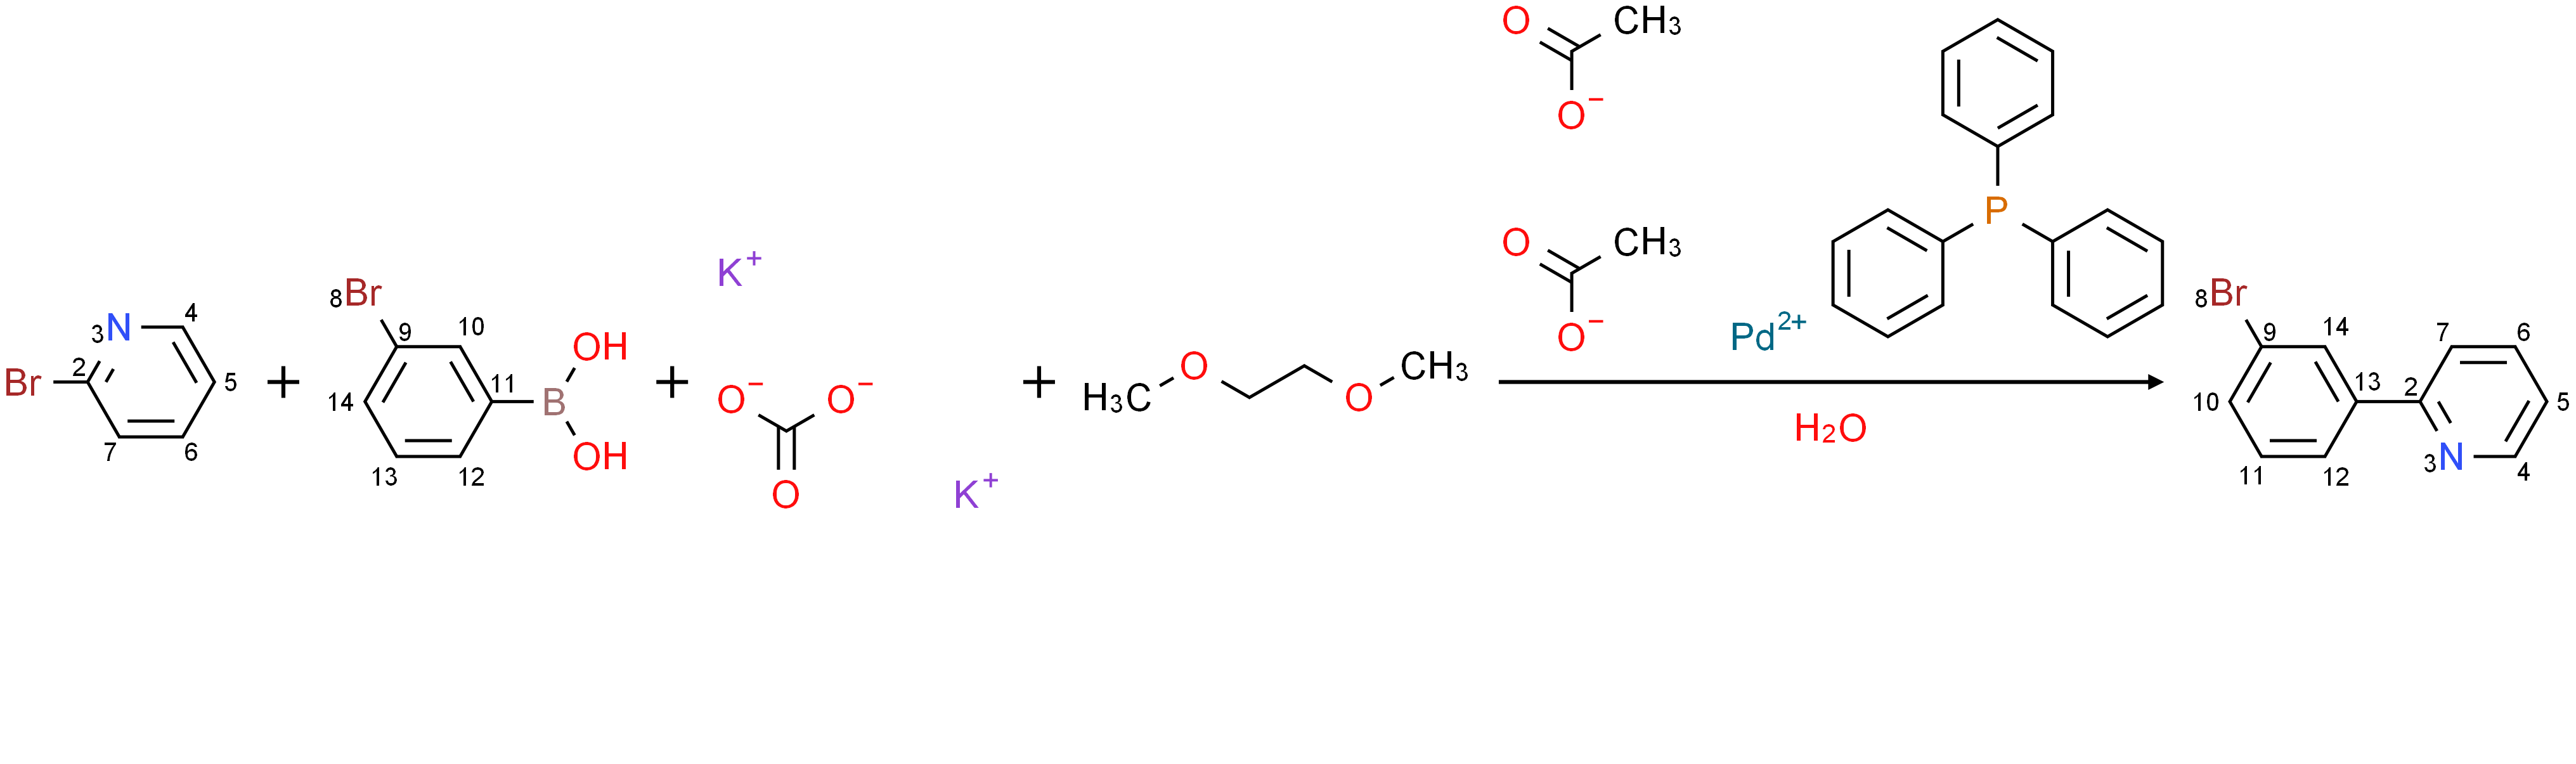

Patent:           US09076973B2
Reaction_id:      ord-f7dcd5a338bf4b41a8918bdae98e53b5
2-bromopyridine (75.0 g, 475 mmol), 3-bromophenylboronic acid (104.8 g, 520 mmol), palladium acetate (2.6 g, 2.5 mol %), triphenylphosphine (5.37 g, 5 mol %) and potassium carbonate (196.0 g, 1425 mmol) was placed in a 2 L 3-neck round bottom flask. 500 mL of dimethoxyethane and 500 mL of H2O was added to the flask. Nitrogen was bubbled through the solution for 30 minutes and then the solution was refluxed for 8 h in an atmosphere of nitrogen. The reaction was then allowed to cool to room temperature and the organic phase was separated from the aqueous phase. The aqueous phase was washed with ethylacetate and the organic fractions were combined and dried over magnesium sulfate and the solvent removed under vacuum. The product was chromatographed using silica gel with ethylacetate and hexanes as the eluent. The solvent was removed to give 84.0 g of a clear oil (76% yield).
CPU times: total: 250 ms
Wall

In [16]:
%%time
# unique to rdkit
draw_reaction(unique_rdkit)

In [17]:
unique_indigo = df[suzuki_indigo & ~suzuki_rdkit]

C:\Users\ergot\AppData\Local\Temp\ipykernel_33132\3555911165.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_indigo = df[suzuki_indigo & ~suzuki_rdkit]


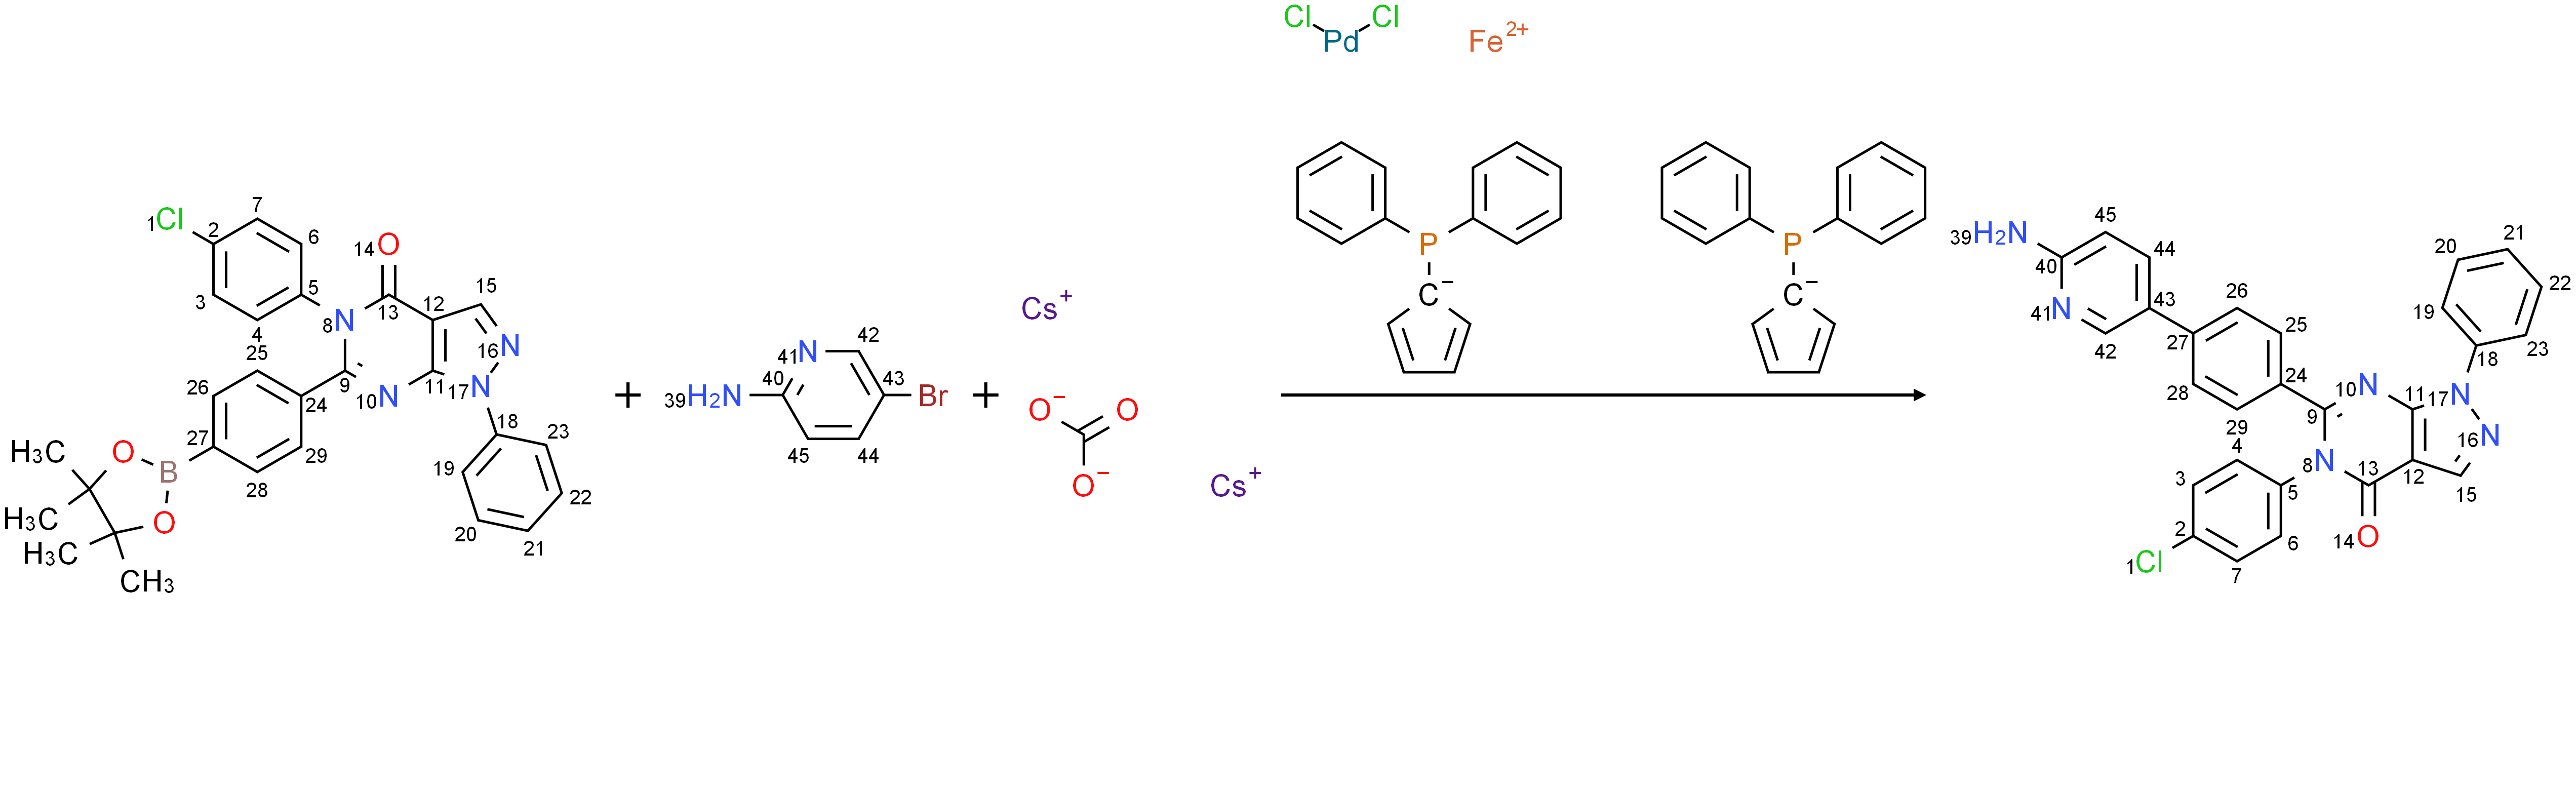

Patent:           US08158634B2
Reaction_id:      ord-c81b6068819e4d048faa8d796874b539
A reaction tube charged with 5-(4-chloro-phenyl)-1-phenyl-6-[4-(4,4,5,5-tetramethyl-[1,3,2]dioxaborolan-2-yl)-phenyl]-1,5-dihydro-pyrazolo[3,4-d]pyrimidin-4-one (500.0 mg, 0.953 mmol), 2-amino-5-bromopyridine (247.3 mg, 1.43 mmol), Cs2CO3 (620.8 mg, 1.91 mmol), and Pd(dppf)2Cl2 (38.9 mg, 0.048 mmol) is purged with nitrogen. Anhydrous DMF (9.5 mL) is added via syringe. The reaction mixture is heated at 100° C. for overnight, cooled down to room temperature, then taken in H2O (100 mL) and ethyl acetate (50 mL). The insoluble solid is filtered off and the two layers of the filtrate are separated. The aqueous layer is extracted with ethyl acetate (2×50 mL). The combined organic phase is washed with brine, dried over MgSO4, concentrated, and purified by reverse phase HPLC to provide 6-[4-(6-amino-pyridin-3-yl)-phenyl]-5-(4-chloro-phenyl)-1-phenyl-1,5-dihydro-pyrazolo[3,4-d]pyrimidin-4-one (244.2 mg, 52% yi

In [18]:
# unique to indigo
draw_reaction(unique_indigo)

In [19]:
# union of {rdkit} and {indigo} subsets
suzuki_df = df[suzuki_rdkit | suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_33132\728856817.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  suzuki_df = df[suzuki_rdkit | suzuki_indigo]


In [20]:
%%time
suzuki_df.to_pickle(f"{ORD_PATH}/suzuki_rxn.pkl.zst")

CPU times: total: 438 ms
Wall time: 444 ms


In [21]:
suzuki_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56665 entries, ord-205c29c6463642c4a3ef2726db5ff6fc to ord-7e9dca83f617441ea03c8f72561a3acb
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rxn_smiles  56665 non-null  object 
 1   time        12903 non-null  float64
 2   temp        56665 non-null  float64
 3   yield       26975 non-null  float64
 4   patent      56665 non-null  object 
 5   notes       56665 non-null  object 
dtypes: float64(3), object(3)
memory usage: 3.0+ MB


In [55]:
suzuki_df.rxn_smiles.value_counts()

Br[C:2]1[CH:7]=[CH:6][C:5]([C:8]2[N:17]=[C:16]([NH:18][C:19]3[NH:20][N:21]=[C:22]([CH3:24])[CH:23]=3)[C:15]3[C:10](=[CH:11][CH:12]=[CH:13][CH:14]=3)[N:9]=2)=[CH:4][CH:3]=1.[C:25]1(B(O)O)[CH:30]=[CH:29][CH:28]=[CH:27][CH:26]=1.C([O-])([O-])=O.[Na+].[Na+].C1(P(C2C=CC=CC=2)C2C=CC=CC=2)C=CC=CC=1>C1COCC1.O.C([O-])(=O)C.[Pd+2].C([O-])(=O)C>[C:2]1([C:25]2[CH:30]=[CH:29][CH:28]=[CH:27][CH:26]=2)[CH:7]=[CH:6][C:5]([C:8]2[N:17]=[C:16]([NH:18][C:19]3[NH:20][N:21]=[C:22]([CH3:24])[CH:23]=3)[C:15]3[C:10](=[CH:11][CH:12]=[CH:13][CH:14]=3)[N:9]=2)=[CH:4][CH:3]=1 |f:2.3.4,6.7,8.9.10|                                                                                                                                                                                                                                                                                                                                                                                                                                          

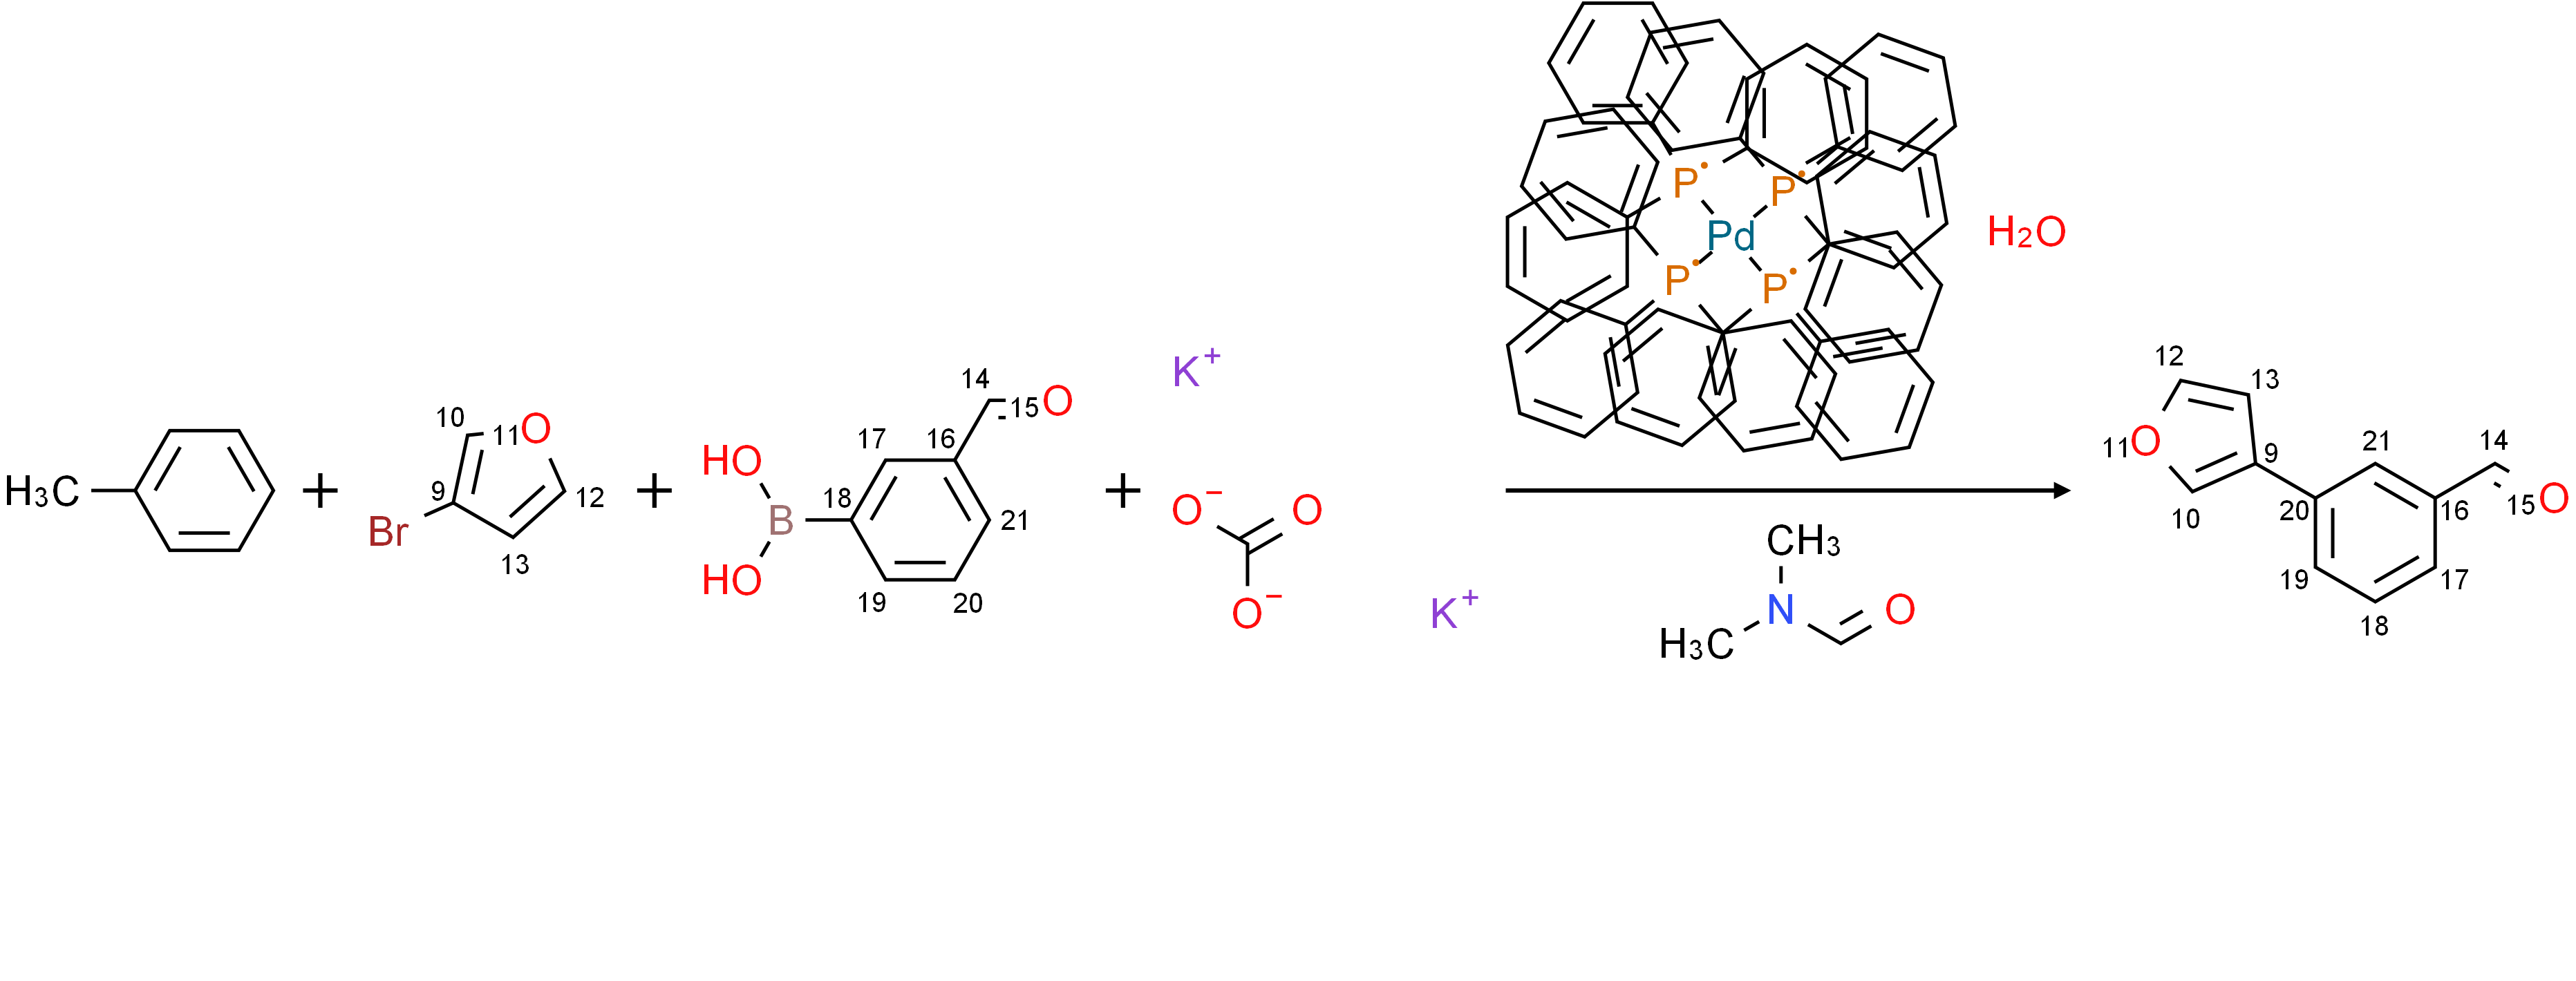

Patent:           US06699898B2
Reaction_id:      ord-eadb7de3d59145d48f3903a7e231f5a5
Ex-601A) To a toluene (10 mL) solution of 3-bromofuran (0.54 mL, 6.0 mmol) was added 3-formylphenylboronic acid (1.00 g, 6.7 mmol) and DMF (4 mL). To the resulting solution was added K2CO3 (1.85 g, 13.4 mmol) and Pd(PPh3)4 (0.40 g, 0.35 mmol). The slurry was heated to reflux under argon for 2 h. The cooled mixture was poured into water and extracted with ethyl acetate. The organic layer was washed with brine, dried (MgSO4) and evaporated to an oil. Purification by flash chromatography on silica gel eluting with 5% ethyl acetate in hexane gave 0.10 g (10%) of the desired 3-(3-furanyl)benzaldehyde product as a yellow oil. MS: m/z=173.0 [M+H]+.


In [85]:
mask = suzuki_df.rxn_smiles == 'C1(C)C=CC=CC=1.Br[C:9]1[CH:13]=[CH:12][O:11][CH:10]=1.[CH:14]([C:16]1[CH:17]=[C:18](B(O)O)[CH:19]=[CH:20][CH:21]=1)=[O:15].C([O-])([O-])=O.[K+].[K+]>C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1.O.CN(C=O)C>[O:11]1[CH:12]=[CH:13][C:9]([C:20]2[CH:21]=[C:16]([CH:17]=[CH:18][CH:19]=2)[CH:14]=[O:15])=[CH:10]1 |f:3.4.5,^1:34,36,55,74|'
draw_reaction(suzuki_df[mask])

In [22]:
%%time
cmpds = pd.read_pickle(f'{ORD_PATH}/uspto_cmpd.pkl.zst')

CPU times: total: 6.11 s
Wall time: 6.13 s


In [23]:
%%time
suzuki_cmpd = cmpds.loc[suzuki_df.index]

CPU times: total: 2.55 s
Wall time: 2.56 s


In [24]:
suzuki_cmpd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349036 entries, ord-205c29c6463642c4a3ef2726db5ff6fc to ord-7e9dca83f617441ea03c8f72561a3acb
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   trivial   43437 non-null   object
 1   name      349036 non-null  object
 2   smiles    339642 non-null  object
 3   rxn_role  349036 non-null  object
dtypes: object(4)
memory usage: 13.3+ MB


In [36]:
suzuki_cmpd.shape

(349036, 4)

In [25]:
%%time
suzuki_cmpd.to_pickle(f"{ORD_PATH}/suzuki_cmpd.pkl.zst")

CPU times: total: 516 ms
Wall time: 508 ms


### Find Pd catalyst

In [46]:
mask = suzuki_cmpd.name.str.contains(r'Pd|[Pp]all?ad')
mask.sum()

38585

In [52]:
pd_cat = suzuki_cmpd[mask]
pd_cat[pd_cat.rxn_role != 4]

,trivial,name,smiles,rxn_role
ord-205c29c6463642c4a3ef2726db5ff6fc,None,tetrakis-(triphenylphosphine)palladium (0),None,1
ord-eb2559d3fc404f17a5ecee988d37d685,None,(tetrakis)triphenylphosphine palladium(0),None,1
ord-32e67c2966e547bfa9726d4db0b83282,None,tetrakistriphenylphosphine palladium (0),None,1
ord-da0442915f5d4115aac6c6d518dc2906,None,tetrakis(triphenylphospine)palladium(0),None,1
ord-08a08e084a414c518c9108c5bc2b198d,None,tetrakistriphenylphosphine palladium(0),None,1
...,...,...,...,...
ord-14562574bdb740b9ab8161be55e4a9dc,None,"[1,1′-bis(diphenyl-phosphino)-ferrocene]dichlo...",None,1
ord-f7b6538c851443228fe9eb318972cb52,None,"(1,1-Bis(diphenylphosphino)ferrocene)-dichloro...",None,1
ord-c56500553e2245769f32645bf3808de0,None,"[1,1′-bis(diphenylphosphino)-ferrocene]dichlor...",None,1
ord-faafb31c9ced45eaa01f039c9c61c420,None,Palladiumtetrakistriphenylphosphine,None,1
